In [1]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from numpy import argmax
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from tqdm import tqdm
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV
import collections
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
import pandas as pd

In [2]:
import numpy as np

In [3]:
human_lombardo = pd.read_csv("../data/human_smiles_r_v3.csv")
human_lombardo = human_lombardo[human_lombardo["smiles_r"]!="Cannot_do"].reset_index(drop=True)
human_lombardo

,smiles_r,human_VDss_L_kg,human_CL_mL_min_kg,human_fup,human_mrt,human_thalf,MW,HBA,HBD,TPSA_NO,RotBondCount,MoKa.LogP,MoKa.LogD7.4,molecular_weight_smiles_r
0,C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...,1.015,4.35,0.33,3.70,15.00,477.47,12.0,5.0,207.3,11.0,0.35,-6.00,475.161514
1,C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1,12.000,8.90,NaN,22.30,50.70,300.44,2.0,1.0,37.3,6.0,5.40,5.40,299.201654
2,C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...,0.530,0.29,0.01,30.38,78.50,532.53,12.0,4.0,169.8,11.0,2.40,-2.60,529.176450
3,C#CC[NH+](C)C(C)Cc1ccccc1,1.900,20.00,0.13,1.60,1.30,187.28,1.0,0.0,3.2,5.0,2.80,2.30,188.143376
4,C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...,1.100,1.60,NaN,11.70,10.90,267.24,8.0,4.0,130.8,3.0,-3.20,-3.20,267.085521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1278,c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2,3.600,8.00,NaN,10.50,8.20,220.27,4.0,1.0,33.7,1.0,0.93,-0.46,221.128454
1279,c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1,6.900,5.10,0.35,23.00,16.00,243.39,1.0,0.0,3.2,2.0,5.30,3.70,244.205976
1280,c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1,4.100,8.60,0.50,7.80,7.30,262.35,2.0,1.0,24.4,3.0,2.80,-0.64,263.154275
1281,c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1,3.900,19.67,NaN,3.45,2.29,265.35,3.0,1.0,27.6,5.0,2.80,0.28,266.165174


In [4]:
human_lombardo=  human_lombardo[["smiles_r","human_VDss_L_kg", "human_CL_mL_min_kg"
                               ,"human_fup", "human_mrt", "human_thalf" ]]
human_smiles = human_lombardo[["smiles_r"]]
human_lombardo
for endpoint in ["human_VDss_L_kg","human_CL_mL_min_kg", "human_mrt", "human_thalf" ]:
    print("Transformed endpoint to log base 10")
    human_lombardo[endpoint] = np.log10(human_lombardo[endpoint])
human_lombardo

Transformed endpoint to log base 10
Transformed endpoint to log base 10
Transformed endpoint to log base 10
Transformed endpoint to log base 10


/tmp/ipykernel_148973/3302494870.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_lombardo[endpoint] = np.log10(human_lombardo[endpoint])


,smiles_r,human_VDss_L_kg,human_CL_mL_min_kg,human_fup,human_mrt,human_thalf
0,C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...,0.006466,0.638489,0.33,0.568202,1.176091
1,C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1,1.079181,0.949390,NaN,1.348305,1.705008
2,C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...,-0.275724,-0.537602,0.01,1.482588,1.894870
3,C#CC[NH+](C)C(C)Cc1ccccc1,0.278754,1.301030,0.13,0.204120,0.113943
4,C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...,0.041393,0.204120,NaN,1.068186,1.037426
...,...,...,...,...,...,...
1278,c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2,0.556303,0.903090,NaN,1.021189,0.913814
1279,c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1,0.838849,0.707570,0.35,1.361728,1.204120
1280,c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1,0.612784,0.934498,0.50,0.892095,0.863323
1281,c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1,0.591065,1.293804,NaN,0.537819,0.359835


In [5]:
human_lombardo = human_lombardo.groupby('smiles_r').median().reset_index()
human_lombardo

,smiles_r,human_VDss_L_kg,human_CL_mL_min_kg,human_fup,human_mrt,human_thalf
0,C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...,0.006466,0.638489,0.33,0.568202,1.176091
1,C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1,1.079181,0.949390,NaN,1.348305,1.705008
2,C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...,-0.275724,-0.537602,0.01,1.482588,1.894870
3,C#CC[NH+](C)C(C)Cc1ccccc1,0.278754,1.301030,0.13,0.204120,0.113943
4,C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...,0.041393,0.204120,NaN,1.068186,1.037426
...,...,...,...,...,...,...
1278,c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2,0.556303,0.903090,NaN,1.021189,0.913814
1279,c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1,0.838849,0.707570,0.35,1.361728,1.204120
1280,c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1,0.612784,0.934498,0.50,0.892095,0.863323
1281,c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1,0.591065,1.293804,NaN,0.537819,0.359835


In [6]:
from sklearn.feature_selection import VarianceThreshold
from rdkit.Chem import AllChem
from itertools import compress

In [7]:
from rdkit.Chem import MACCSkeys
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from pandarallel import pandarallel
from rdkit import Chem
from mordred import Calculator, descriptors
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect

def MorganFingerprint(s):
    x = Chem.MolFromSmiles(s)
    return (AllChem.GetMorganFingerprintAsBitVect(x,2,2048))

def GetMACCSkeys(s):
    x = Chem.MolFromSmiles(s)
    return (MACCSkeys.GenMACCSKeys(x))

def addfps(data, fn, nm):
    pandarallel.initialize()
    array=[]
    array = np.stack(data['smiles_r'].parallel_apply(fn))
    collection = []
    for x in np.arange(array.shape[1]):
        x = nm+str(x)
        collection.append(x)
    table = pd.DataFrame(array, columns=collection)
    df= pd.concat([data, table], axis=1)
    return df

In [8]:
human_lombardo=addfps(human_lombardo, MorganFingerprint, 'M')
human_lombardo

INFO: Pandarallel will run on 112 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


,smiles_r,human_VDss_L_kg,human_CL_mL_min_kg,human_fup,human_mrt,human_thalf,M0,M1,M2,M3,...,M2038,M2039,M2040,M2041,M2042,M2043,M2044,M2045,M2046,M2047
0,C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...,0.006466,0.638489,0.33,0.568202,1.176091,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1,1.079181,0.949390,NaN,1.348305,1.705008,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...,-0.275724,-0.537602,0.01,1.482588,1.894870,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,C#CC[NH+](C)C(C)Cc1ccccc1,0.278754,1.301030,0.13,0.204120,0.113943,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...,0.041393,0.204120,NaN,1.068186,1.037426,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1278,c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2,0.556303,0.903090,NaN,1.021189,0.913814,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1279,c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1,0.838849,0.707570,0.35,1.361728,1.204120,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1280,c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1,0.612784,0.934498,0.50,0.892095,0.863323,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1281,c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1,0.591065,1.293804,NaN,0.537819,0.359835,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
import pandas as pd

#Morgan Fingerprint Correlations
#Active vs Inactive

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
import pandas as pd

    # proof and make a list of SMILES
def calculate_similarity_alldata(data):
    
    df_smiles = data['smiles_r']
    c_smiles = []
    
    for ds in df_smiles:
        try:
            cs = Chem.CanonSmiles(ds)
            c_smiles.append(cs)
        except:
            print('Invalid SMILES:', ds)
    print()

    # make a list of mols
    ms = [Chem.MolFromSmiles(x) for x in c_smiles]

    # make a list of fingerprints (fp)
    fps = [AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=2048) for x in ms]
    print(len(fps))

    # the list for the dataframe
    qu, ta, sim = [], [], []

    # compare all fp pairwise without duplicates
    for n in range(len(fps)): # -1 so the last fp will not be used
        s = DataStructs.BulkTanimotoSimilarity(fps[n], fps[:]) # +1 compare with the next to the last fp
        #print(c_smiles[n], c_smiles[n+1:]) # witch mol is compared with what group
        # collect the SMILES and values
        for m in range(len(s)):
            qu.append(c_smiles[n])
            ta.append(c_smiles[:][m])
            sim.append(s[m])


    # build the dataframe and sort it
    d = {'query':qu, 'target':ta, 'MFP_Tc':sim}
    df_final_aa = pd.DataFrame(data=d)
    df_final_aa = df_final_aa.sort_values('MFP_Tc', ascending=False)
    df_final_aa=df_final_aa.reset_index()
    df_final_aa = df_final_aa[df_final_aa["query"] != df_final_aa["target"]]
    return(df_final_aa)

    # save as csv
    #df_final.to_csv('third.csv', index=False, sep=',')

In [10]:
import numpy as np

def quantile_curves(D):

    quantiles = [0.25, 0.5, 0.75]
    print('quantiles:\n', quantiles)

    moments = [f'moment {i}' for i in range(1)]

    #D = np.array(df_plot[df_plot["Category"]=="Toxic vs Toxic"]["MFP_Tc"])

    quantile_values = np.quantile(D , quantiles , axis=0)
    print('quantile_values (for each moment):\n', quantile_values)

    quantile_curves = np.zeros((len(quantiles)+1))

    quantile_curves[0] = np.mean(np.ma.masked_array(D, mask=D>quantile_values[0]), axis=0)
    for q in range(len(quantiles)-1):
      quantile_curves[q+1] = np.mean(np.ma.masked_array(D, mask=np.logical_or(D<quantile_values[q], D>quantile_values[q+1])), axis=0)
    quantile_curves[len(quantiles)] = np.mean(np.ma.masked_array(D, mask=D<quantile_values[len(quantiles)-1]), axis=0)

    print('mean for each group and at each moment:')
    print(quantile_curves)
    return(quantile_curves)

In [11]:
import pickle
from tqdm import tqdm

n_neighbours=5

df = human_lombardo
       
df_final_aa = calculate_similarity_alldata(human_lombardo.iloc[:, :1])
df_final_aa = df_final_aa.sort_values('MFP_Tc', ascending=False)
df_final_aa = df_final_aa.reset_index()
df_final_aa


df_final_aa_2 = pd.DataFrame()

for compound in tqdm(df_final_aa["query"].unique()):
    
    #print(compound)

    compounds_wise = pd.DataFrame()
    compounds_wise = df_final_aa[df_final_aa["query"]==compound].sort_values("MFP_Tc", ascending=False).iloc[:n_neighbours, :]
    df_final_aa_2 = pd.concat([df_final_aa_2, compounds_wise])

          
df_master = df_final_aa_2.groupby('query').mean().sort_values("MFP_Tc").reset_index()
df_master


1283


100%|███████████████████████████████████████| 1283/1283 [00:58<00:00, 22.02it/s]


,query,level_0,index,MFP_Tc
0,FC(F)(F)C(F)(F)C(F)(F)F,1092106.8,1273467.6,0.079048
1,N#C[NH3+],968088.2,1281271.8,0.085887
2,S=P([NH+]1CC1)([NH+]1CC1)[NH+]1CC1,745839.2,1580155.4,0.098095
3,NC(O)=NO,301096.0,1322364.6,0.129865
4,C1COC(NC(C2CC2)C2CC2)=[NH+]1,193258.2,26329.0,0.144402
...,...,...,...,...
1278,COc1cccc2c1C(=O)c1c([O-])c3c(c([O-])c1C2=O)C[C...,1397.4,839620.2,0.814475
1279,COc1cccc2c1C(=N)c1c([O-])c3c(c([O-])c1C2=O)C[C...,1404.6,830766.4,0.821245
1280,COc1cccc2c1C(=O)c1c([O-])c3c(c([O-])c1C2=O)C[C...,1380.6,835883.0,0.821849
1281,COc1cccc2c1C(=O)c1c([O-])c3c(c([O-])c1C2=O)C[C...,1298.0,834601.4,0.884090


In [12]:
df_master.to_csv("human_trainingdata_5nn_similarity_all_compounds.csv", index=False)
df_master

,query,level_0,index,MFP_Tc
0,FC(F)(F)C(F)(F)C(F)(F)F,1092106.8,1273467.6,0.079048
1,N#C[NH3+],968088.2,1281271.8,0.085887
2,S=P([NH+]1CC1)([NH+]1CC1)[NH+]1CC1,745839.2,1580155.4,0.098095
3,NC(O)=NO,301096.0,1322364.6,0.129865
4,C1COC(NC(C2CC2)C2CC2)=[NH+]1,193258.2,26329.0,0.144402
...,...,...,...,...
1278,COc1cccc2c1C(=O)c1c([O-])c3c(c([O-])c1C2=O)C[C...,1397.4,839620.2,0.814475
1279,COc1cccc2c1C(=N)c1c([O-])c3c(c([O-])c1C2=O)C[C...,1404.6,830766.4,0.821245
1280,COc1cccc2c1C(=O)c1c([O-])c3c(c([O-])c1C2=O)C[C...,1380.6,835883.0,0.821849
1281,COc1cccc2c1C(=O)c1c([O-])c3c(c([O-])c1C2=O)C[C...,1298.0,834601.4,0.884090


In [13]:
len(df_master[df_master["MFP_Tc"]<=0.3])/len(df_master)

0.38893219017926733

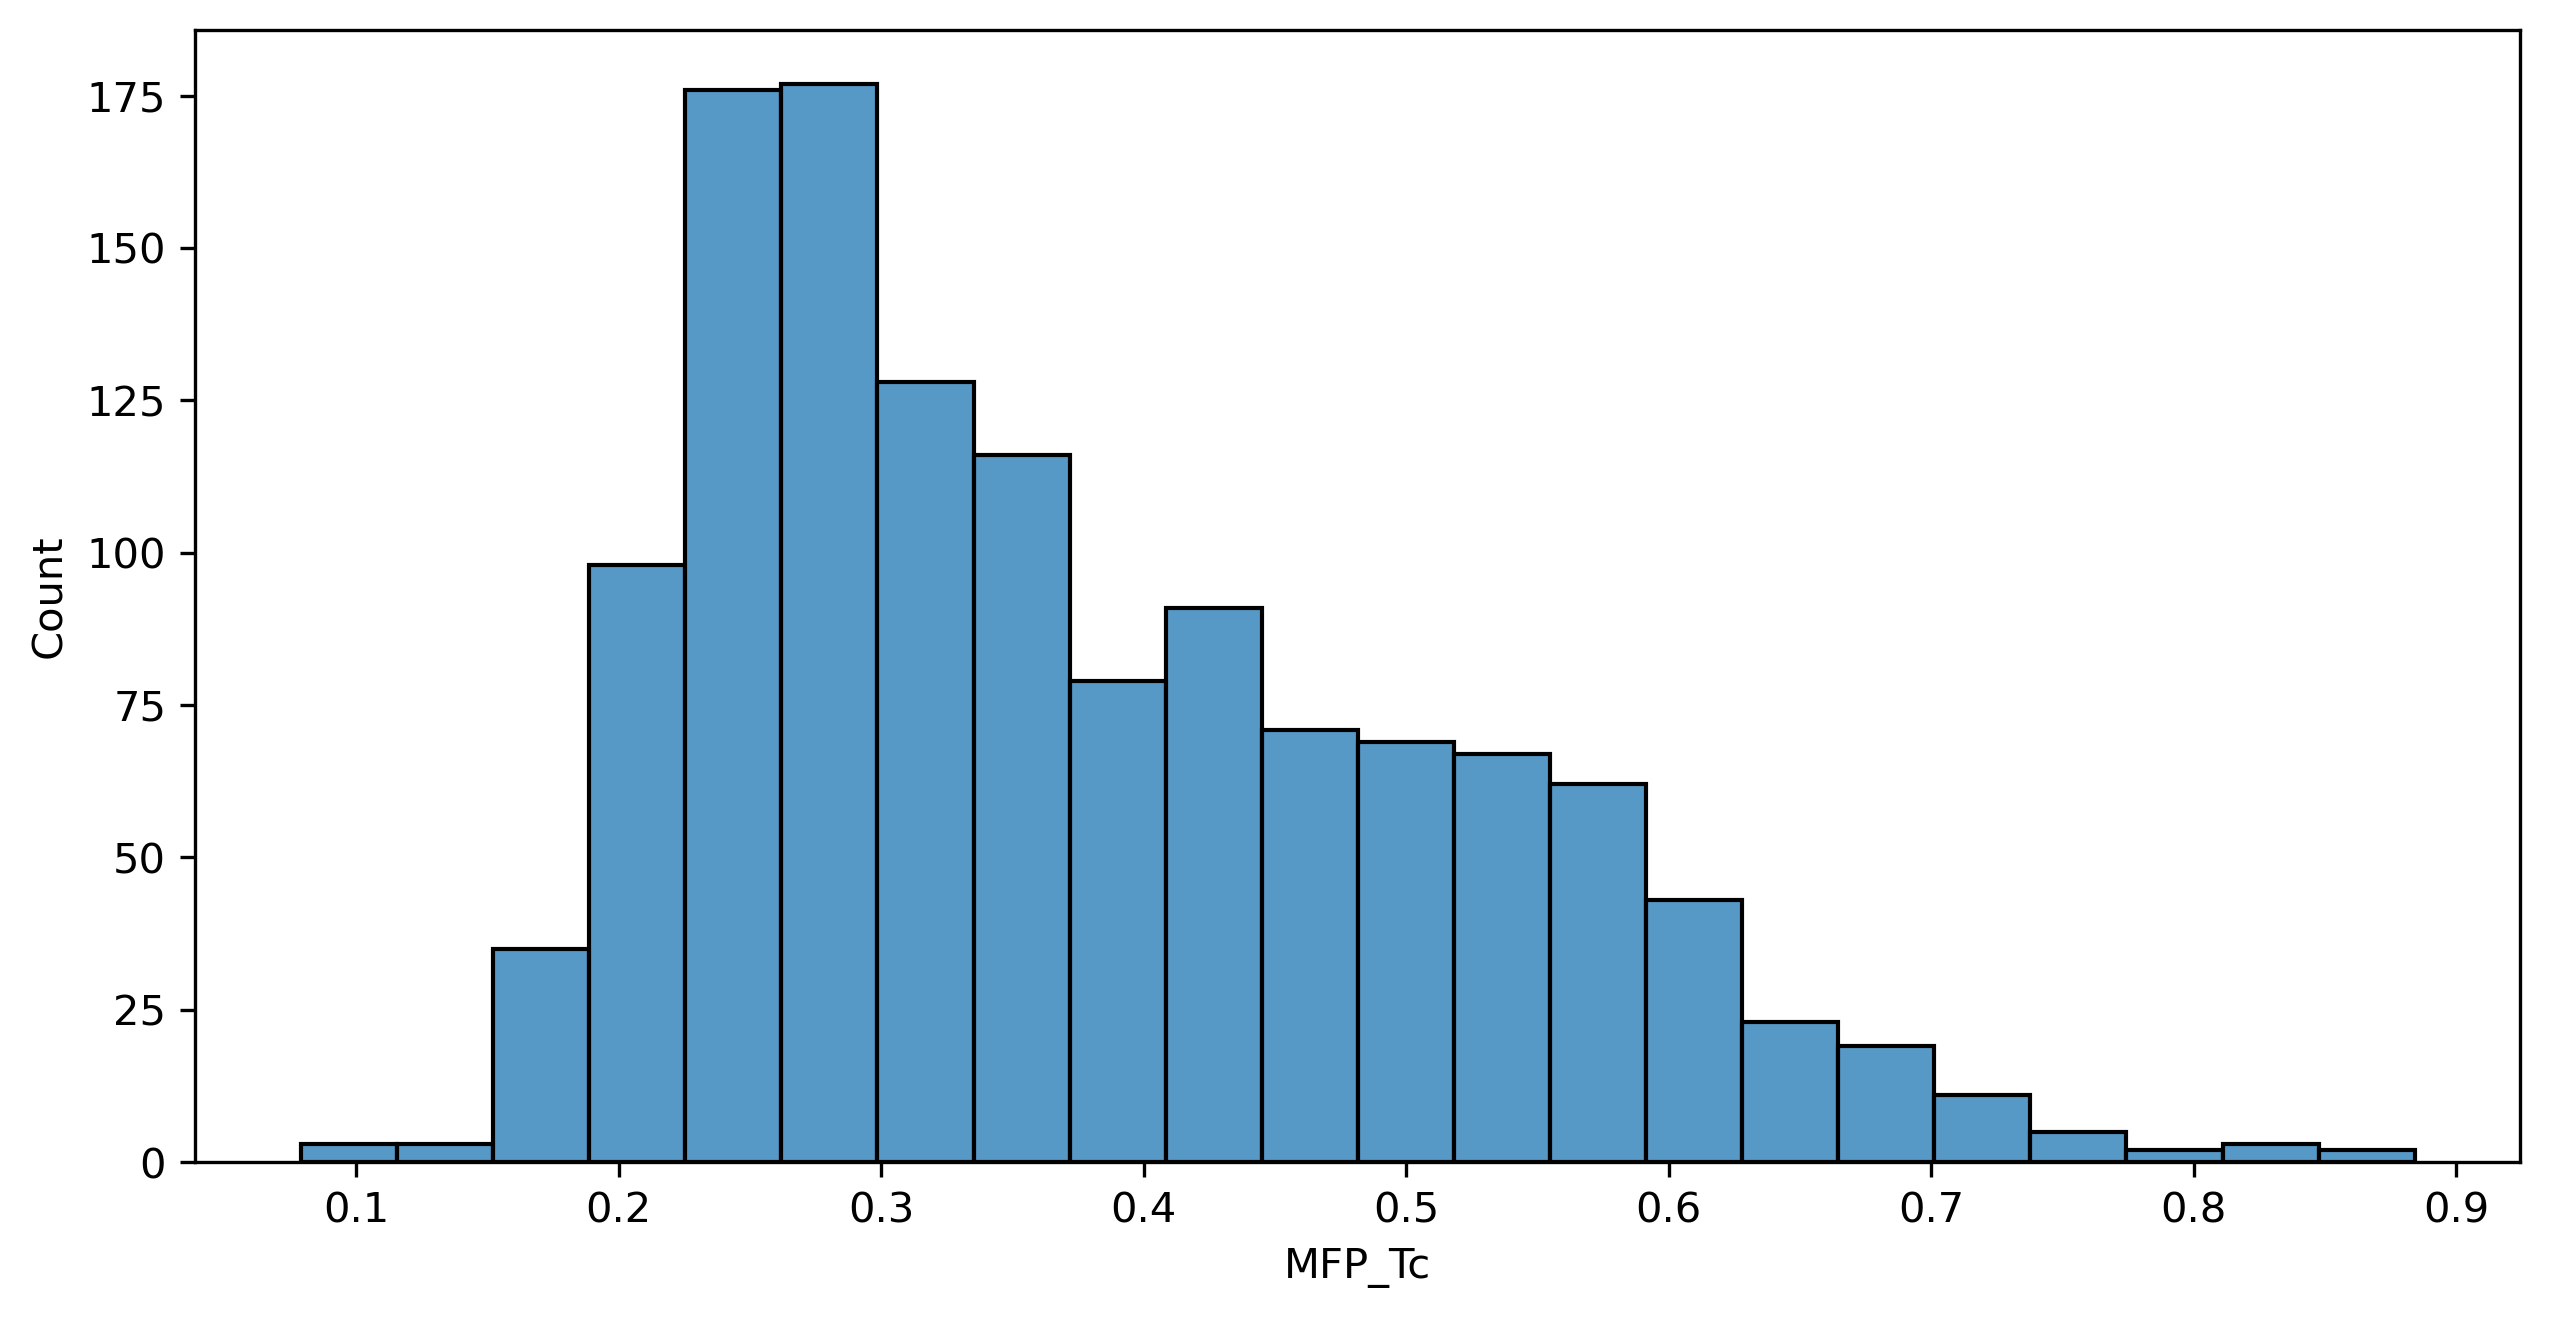

In [14]:
plt.figure(figsize=(10,5), dpi= 300)
sns.histplot(data=df_master, x="MFP_Tc")
plt.show()

In [15]:
#Per endpoint Tc

df_master=pd.DataFrame()
n_neighbours = 5

for endpoint in ["human_VDss_L_kg","human_CL_mL_min_kg", "human_fup", "human_mrt", "human_thalf"]:

    print(endpoint)    
    df = human_lombardo.dropna(subset=[endpoint]).reset_index(drop=True)
        
        
    df_final_aa = calculate_similarity_alldata(df.iloc[:,:])
    df_final_aa = df_final_aa.sort_values('MFP_Tc', ascending=False)
    df_final_aa = df_final_aa.reset_index()
    df_final_aa


    df_final_aa_2 = pd.DataFrame()

    for compound in tqdm(df_final_aa["query"].unique()):
        #print(compound)

        compounds_wise = pd.DataFrame()
        compounds_wise = df_final_aa[df_final_aa["query"]==compound].sort_values("MFP_Tc", ascending=False).iloc[:n_neighbours, :]
        df_final_aa_2 = pd.concat([df_final_aa_2, compounds_wise])    
    
    df_final_aa_2 = df_final_aa_2.groupby('query').mean().sort_values("MFP_Tc").reset_index()
    df_final_aa_2["endpoint"]=endpoint

    df_master = pd.concat([df_master, df_final_aa_2])
    #print(endpoint)   
    #print("Over")  
    df_master
        
        

human_VDss_L_kg

1249


100%|███████████████████████████████████████| 1249/1249 [00:53<00:00, 23.27it/s]


human_CL_mL_min_kg

1281


100%|███████████████████████████████████████| 1281/1281 [00:57<00:00, 22.12it/s]


human_fup

879


100%|█████████████████████████████████████████| 879/879 [00:19<00:00, 46.01it/s]


human_mrt

1243


100%|███████████████████████████████████████| 1243/1243 [00:52<00:00, 23.54it/s]


human_thalf

1265


100%|███████████████████████████████████████| 1265/1265 [00:55<00:00, 22.76it/s]


In [16]:
df_master

,query,level_0,index,MFP_Tc,endpoint
0,FC(F)(F)C(F)(F)C(F)(F)F,1034434.0,1205997.2,0.079048,human_VDss_L_kg
1,N#C[NH3+],918347.6,1213594.6,0.085887,human_VDss_L_kg
2,S=P([NH+]1CC1)([NH+]1CC1)[NH+]1CC1,706037.2,1497063.8,0.098095,human_VDss_L_kg
3,NC(O)=NO,283280.2,1253598.8,0.129865,human_VDss_L_kg
4,C1COC(NC(C2CC2)C2CC2)=[NH+]1,182161.0,25631.2,0.144402,human_VDss_L_kg
...,...,...,...,...,...
1260,COc1cccc2c1C(=O)c1c([O-])c3c(c([O-])c1C2=O)C[C...,1379.8,820253.2,0.814475,human_thalf
1261,COc1cccc2c1C(=N)c1c([O-])c3c(c([O-])c1C2=O)C[C...,1386.0,811524.2,0.821245,human_thalf
1262,COc1cccc2c1C(=O)c1c([O-])c3c(c([O-])c1C2=O)C[C...,1362.8,816569.0,0.821849,human_thalf
1263,COc1cccc2c1C(=O)c1c([O-])c3c(c([O-])c1C2=O)C[C...,1282.6,817835.0,0.884090,human_thalf


In [17]:
df_master.loc[df_master['MFP_Tc'] <= 0.20, 'Within Applicability Domain?'] = False 
df_master.loc[df_master['MFP_Tc'] > 0.20, 'Within Applicability Domain?'] = True 
df_master = df_master.rename(columns={"MFP_Tc": "5-nearest Neighbour Tanimoto similarity", "endpoint": "Endpoint"})

df_master = df_master.replace({"human_VDss_L_kg": "Human Volume of distribution (VDss)",
                                     "human_CL_mL_min_kg": "Human Clearance (CL)",
                                     "human_fup": "Human Fraction unbound in plasma (fup)",
                                     "human_mrt": "Human Mean Residence Time (MRT)",
                                     "human_thalf": "Human Half-life (thalf)"})

df_master.to_csv("human_trainingdata_5nn_similarity_all_compounds_endpoint_wise.csv", index=False)
df_master

,query,level_0,index,5-nearest Neighbour Tanimoto similarity,Endpoint,Within Applicability Domain?
0,FC(F)(F)C(F)(F)C(F)(F)F,1034434.0,1205997.2,0.079048,Human Volume of distribution (VDss),False
1,N#C[NH3+],918347.6,1213594.6,0.085887,Human Volume of distribution (VDss),False
2,S=P([NH+]1CC1)([NH+]1CC1)[NH+]1CC1,706037.2,1497063.8,0.098095,Human Volume of distribution (VDss),False
3,NC(O)=NO,283280.2,1253598.8,0.129865,Human Volume of distribution (VDss),False
4,C1COC(NC(C2CC2)C2CC2)=[NH+]1,182161.0,25631.2,0.144402,Human Volume of distribution (VDss),False
...,...,...,...,...,...,...
1260,COc1cccc2c1C(=O)c1c([O-])c3c(c([O-])c1C2=O)C[C...,1379.8,820253.2,0.814475,Human Half-life (thalf),True
1261,COc1cccc2c1C(=N)c1c([O-])c3c(c([O-])c1C2=O)C[C...,1386.0,811524.2,0.821245,Human Half-life (thalf),True
1262,COc1cccc2c1C(=O)c1c([O-])c3c(c([O-])c1C2=O)C[C...,1362.8,816569.0,0.821849,Human Half-life (thalf),True
1263,COc1cccc2c1C(=O)c1c([O-])c3c(c([O-])c1C2=O)C[C...,1282.6,817835.0,0.884090,Human Half-life (thalf),True


In [18]:
animal = pd.read_csv("../data/animal_smiles_r_v3.csv")
animal

,CHEMISTRY,NAME,human_CL_mL_min_kg,rat_CL_mL_min_kg,dog_CL_mL_min_kg,monkey_CL_mL_min_kg,human_VDss_L_kg,rat_VDss_L_kg,dog_VDss_L_kg,monkey_VDss_L_kg,human_fup,rat_fup,dog_fup,monkey_fup,smiles_r,InChICode_standardised,molecular_weight_smiles_r
0,Fc1c[nH]c(=O)[nH]c1=O,5-Fluorouracil,26.0,33.0,NaN,NaN,0.23,0.25,NaN,NaN,0.6400,0.690,NaN,NaN,O=c1[n-]cc(F)c(=O)[n-]1,"InChI=1S/C4H3FN2O2/c5-2-1-6-4(9)7-3(2)8/h1H,(H...",128.003303
1,[nH]1cnc(=S)c(c12)[nH]cn2,6-Mercaptopurine,15.0,NaN,NaN,15.2,1.00,NaN,NaN,0.9,0.8500,NaN,NaN,NaN,S=c1nc[n-]c2nc[n-]c12,InChI=1S/C5H3N4S/c10-5-3-4(7-1-6-3)8-2-9-5/h1-...,150.001114
2,CO[C@@H]1[C@H](NC)C[C@@H](O2)n(c3c4n5[C@]12C)c...,7-Hydroxystaurosporine,0.0,65.0,10.20,NaN,0.15,16.70,6.09,NaN,0.0022,NaN,0.0074,NaN,C[NH2+][C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3c...,InChI=1S/C28H26N4O4/c1-28-25(35-3)15(29-2)12-1...,483.202682
3,C1OC(=O)[C@](O)(CC)c(c12)cc3n(c2=O)Cc4c3nc5c(c...,9-Aminocamptothecin,6.5,150.0,NaN,NaN,2.20,5.00,NaN,NaN,0.0030,NaN,NaN,NaN,CC[C@@]1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(N)cccc...,InChI=1S/C20H17N3O4/c1-2-20(26)13-7-16-17-10(6...,363.121906
4,OC[C@@H]1C=C[C@@H](C1)n(cn2)c(c23)nc(N)nc3NC4CC4,Abacavir,13.0,30.0,NaN,NaN,0.84,NaN,NaN,NaN,0.5000,NaN,NaN,NaN,Nc1nc([NH2+]C2CC2)c2ncn([C@H]3C=C[C@@H](CO)C3)...,InChI=1S/C14H18N6O/c15-14-18-12(17-9-2-3-9)11-...,287.161486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,OC[C@@H](O)[C@@H](O)[C@H]1[C@H](NC(=O)C)[C@H](...,Zamivir,1.6,31.7,NaN,NaN,0.23,0.80,NaN,NaN,0.8600,NaN,NaN,NaN,CC(=O)N[C@H]1[C@H]([C@H](O)[C@H](O)CO)OC(C(=O)...,InChI=1S/C12H20N4O7/c1-4(18)15-8-5(16-12(13)14...,332.133199
367,[N-]=[N+]=N[C@H]1C[C@@H](O[C@@H]1CO)n2cc(C)c(=...,Zidovudine,25.0,25.1,14.00,NaN,1.80,0.86,1.00,NaN,0.8000,0.687,0.8270,0.707,Cc1cn([C@H]2C[C@H](N=[N+]=[N-])[C@@H](CO)O2)c(...,InChI=1S/C10H13N5O4/c1-5-3-15(10(18)12-9(5)17)...,266.089477
368,OP(=O)(O)C(O)(P(=O)(O)O)Cn1ccnc1,Zoledronic Acid,2.2,NaN,4.13,NaN,0.60,NaN,0.28,NaN,0.7800,NaN,NaN,NaN,O=P([O-])([O-])C(O)(Cn1ccnc1)P(=O)([O-])[O-],"InChI=1S/C5H10N2O7P2/c8-5(15(9,10)11,16(12,13)...",267.967218
369,O=C1OC[C@@H](N1)Cc(cc2)cc(c23)c(c[nH]3)CCN(C)C,Zolmitriptan,6.7,29.4,NaN,NaN,1.80,3.53,NaN,NaN,0.7500,NaN,NaN,NaN,C[NH+](C)CCc1c[nH]c2ccc(C[C@H]3COC(=O)N3)cc12,InChI=1S/C16H21N3O2/c1-19(2)6-5-12-9-17-15-4-3...,288.170653


In [19]:
import pickle
n_neighbours=5

df = animal
       
df_final_aa = calculate_similarity_alldata(df)
df_final_aa = df_final_aa.sort_values('MFP_Tc', ascending=False)
df_final_aa = df_final_aa.reset_index()
df_final_aa


df_final_aa_2 = pd.DataFrame()

for compound in df_final_aa["query"].unique():
    
    #print(compound)

    compounds_wise = pd.DataFrame()
    compounds_wise = df_final_aa[df_final_aa["query"]==compound].sort_values("MFP_Tc", ascending=False).iloc[:n_neighbours, :]
    df_final_aa_2 = pd.concat([df_final_aa_2, compounds_wise])

          
df_master_animal = df_final_aa_2.groupby('query').mean().sort_values("MFP_Tc").reset_index()
df_master_animal


371


,query,level_0,index,MFP_Tc
0,[H]/[NH+]=C(/N=C([NH3+])[NH3+])N(C)C,80402.4,81132.4,0.088522
1,[NH3+]C12CC3CC(CC(C3)C1)C2,51518.4,6835.8,0.115984
2,CCC1=NC(=O)C2CSSCC/C=C\[C@H](CC(=O)NC(C(C)C)C(...,26965.0,110062.2,0.129618
3,O=P1([NH+](CCCl)CCCl)[NH2+]CCCO1,35161.8,37314.2,0.130622
4,CC[C@@H](CO)[NH2+]CC[NH2+][C@@H](CC)CO,19594.8,49906.2,0.139490
...,...,...,...,...
366,CON=C(C(=O)NC1C(=O)[NH+]2C(C(=O)[O-])=C(CSc3nc...,449.4,29003.2,0.695372
367,CON=C(C(=O)NC1C(=O)[NH+]2C(C(=O)[O-])=C(CSc3nn...,447.6,23441.2,0.697939
368,CON=C(C(=O)NC1C(=O)[NH+]2C(C(=O)[O-])=C(COC(C)...,435.0,25666.0,0.706676
369,COc1cccc2c1C(=O)c1c([O-])c3c(c([O-])c1C2=O)C[C...,969.8,46192.4,0.711431


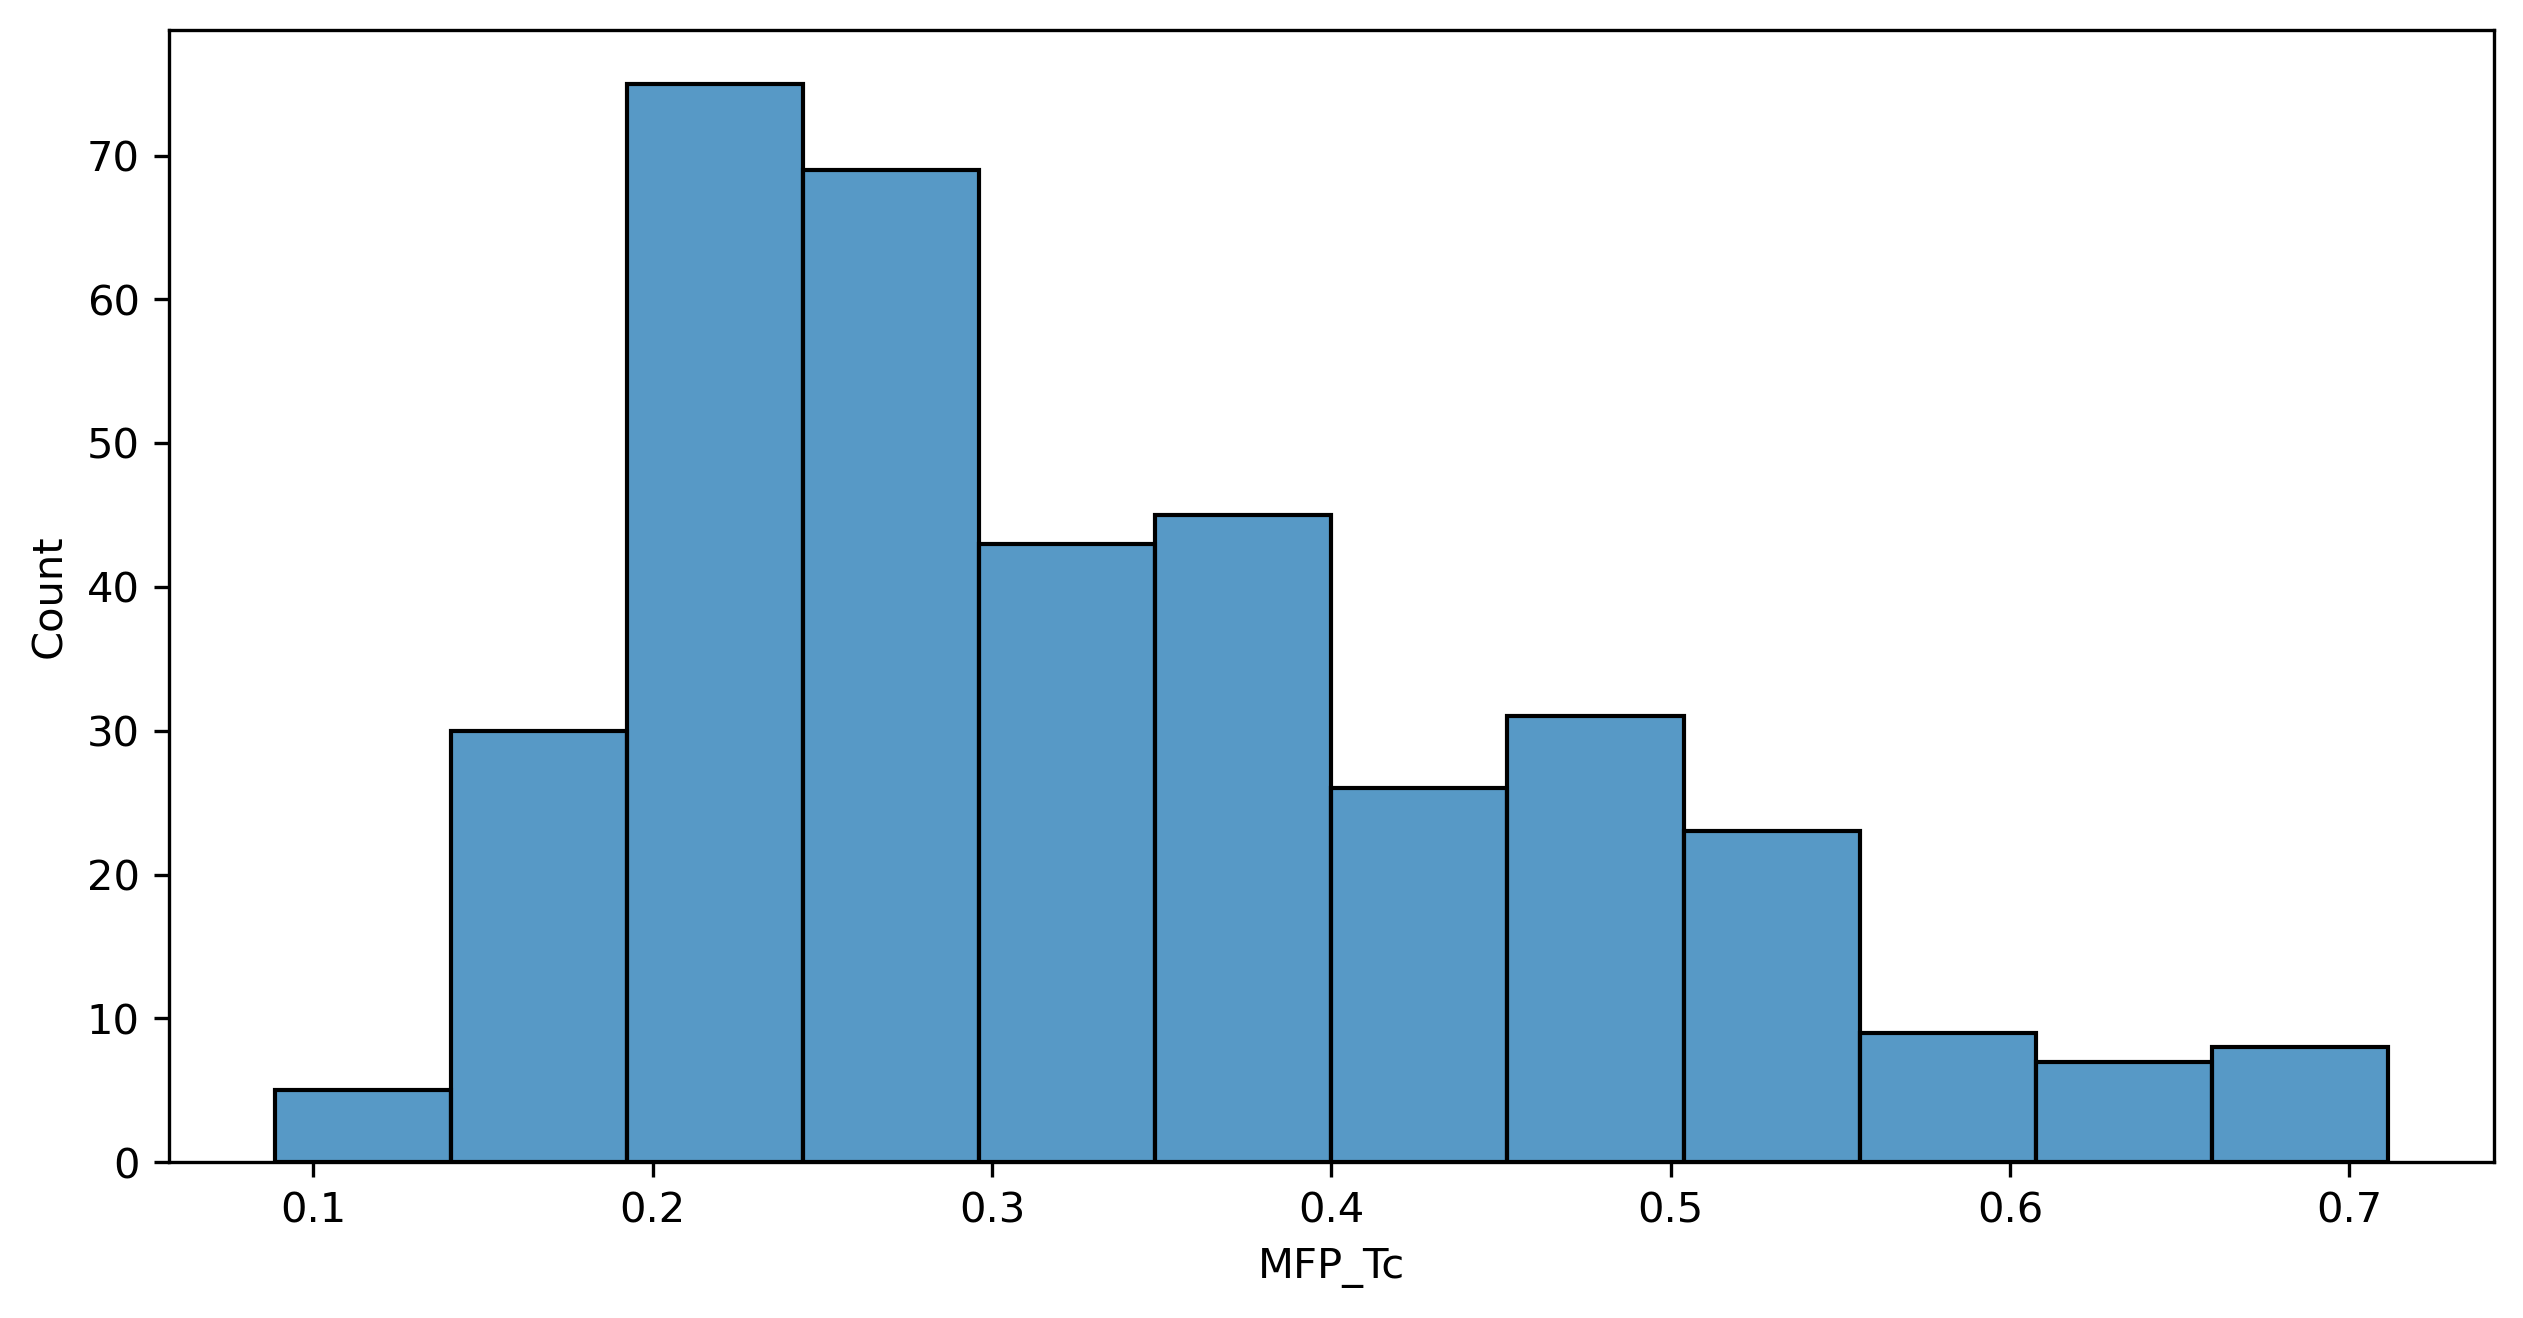

In [20]:
plt.figure(figsize=(10,5), dpi= 300)
sns.histplot(data=df_master_animal, x="MFP_Tc")
plt.show()

In [21]:
len(df_master_animal[df_master_animal["MFP_Tc"]<=0.3])/len(df_master_animal)

0.49326145552560646

In [22]:
df_master_animal.to_csv("animal_trainingdata_5nn_similarity_all_compounds.csv", index=False)
df_master_animal

,query,level_0,index,MFP_Tc
0,[H]/[NH+]=C(/N=C([NH3+])[NH3+])N(C)C,80402.4,81132.4,0.088522
1,[NH3+]C12CC3CC(CC(C3)C1)C2,51518.4,6835.8,0.115984
2,CCC1=NC(=O)C2CSSCC/C=C\[C@H](CC(=O)NC(C(C)C)C(...,26965.0,110062.2,0.129618
3,O=P1([NH+](CCCl)CCCl)[NH2+]CCCO1,35161.8,37314.2,0.130622
4,CC[C@@H](CO)[NH2+]CC[NH2+][C@@H](CC)CO,19594.8,49906.2,0.139490
...,...,...,...,...
366,CON=C(C(=O)NC1C(=O)[NH+]2C(C(=O)[O-])=C(CSc3nc...,449.4,29003.2,0.695372
367,CON=C(C(=O)NC1C(=O)[NH+]2C(C(=O)[O-])=C(CSc3nn...,447.6,23441.2,0.697939
368,CON=C(C(=O)NC1C(=O)[NH+]2C(C(=O)[O-])=C(COC(C)...,435.0,25666.0,0.706676
369,COc1cccc2c1C(=O)c1c([O-])c3c(c([O-])c1C2=O)C[C...,969.8,46192.4,0.711431
